## Ï†ÑÏ≤òÎ¶¨Ìïú Îç∞Ïù¥ÌÑ∞ Í∞ÄÏßÄÍ≥† Ïò§Í∏∞

In [1]:
%pip install -q lightgbm scikit-learn optuna

Note: you may need to restart the kernel to use updated packages.


In [1]:
# „É©„Ç§„Éñ„É©„É™„ÅÆ„Ç§„É≥„Éù„Éº„Éà
import pandas as pd
import lightgbm as lgb
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation 

In [3]:
# „Éá„Éº„ÇøË™≠„ÅøËæº„Åø
df = pd.read_csv('../data/combined_batches_domain_age_clean_5.csv')

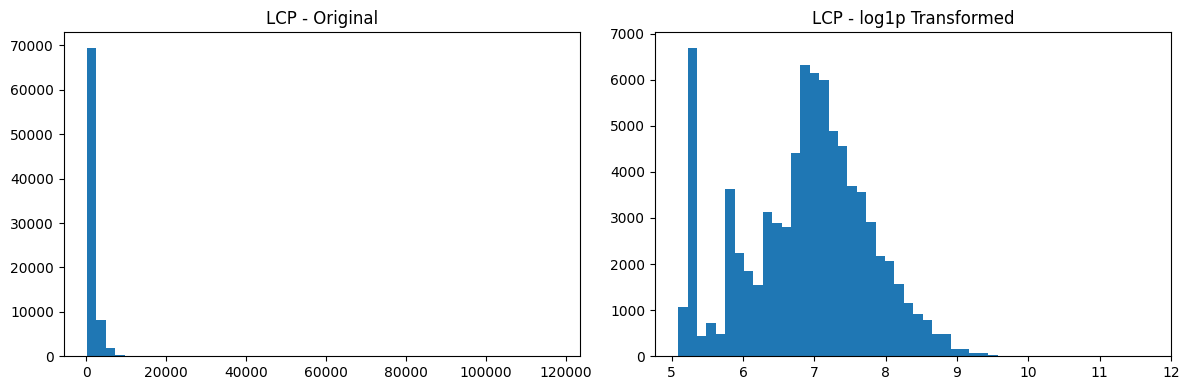

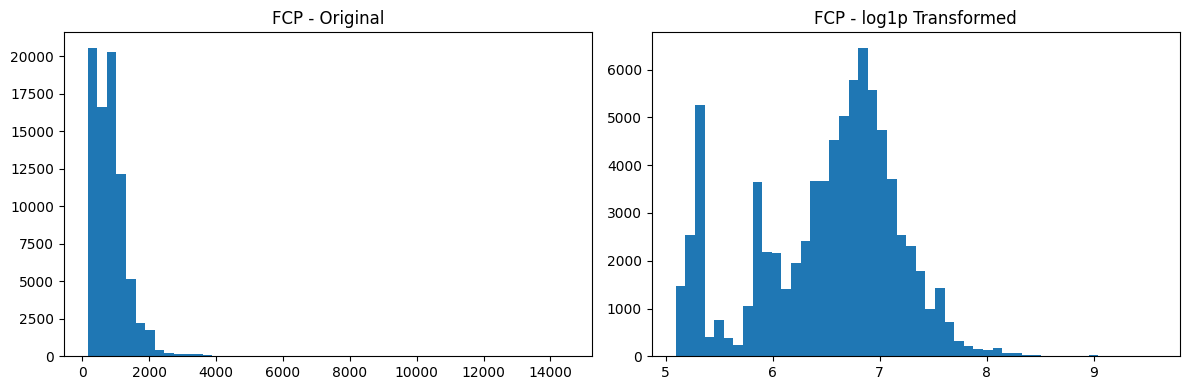

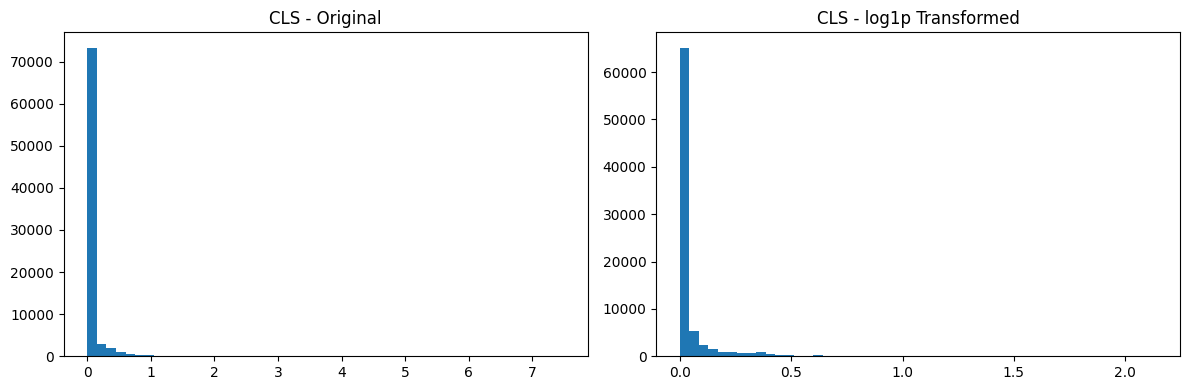

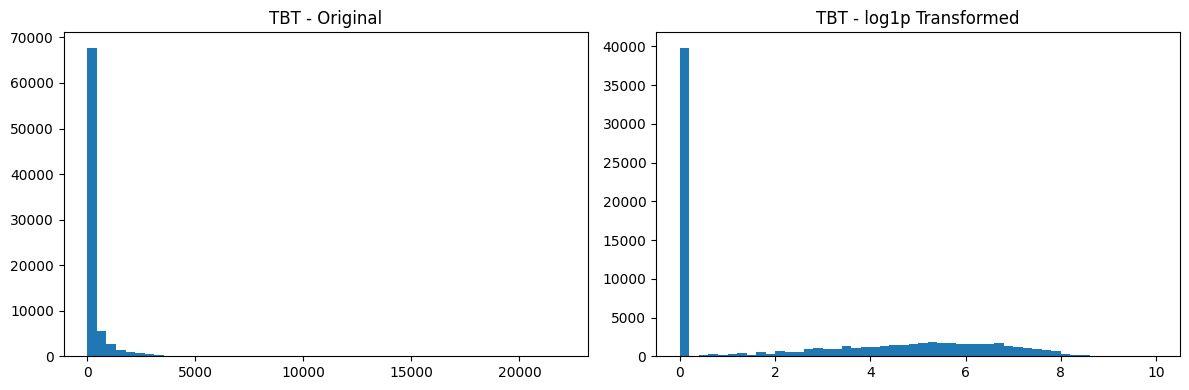

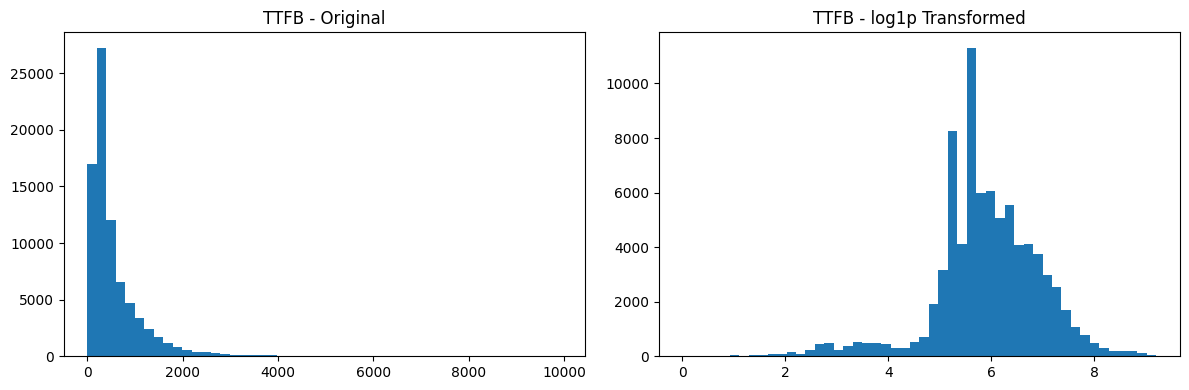

In [4]:
features_to_check = ["LCP", "FCP", "CLS", "TBT" , "TTFB"]

for feat in features_to_check:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[feat].dropna(), bins=50)
    plt.title(f"{feat} - Original")

    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(df[feat].dropna()), bins=50)
    plt.title(f"{feat} - log1p Transformed")

    plt.tight_layout()
    plt.show()


ÁâπÂæ¥Èáè„Å®„É©„Éô„É´„Å´ÂàÜÂâ≤

In [5]:
df['digit_ratio'] = df['digits_count'] / (df['url_len'] + 1e-5)
df['meta_density'] = df['meta_count'] / (df['duration_sec'] + 1e-5)
df['performance_ratio'] = df['SpeedIndex'] / (df['duration_sec'] + 1e-5)

# logÂ§âÊèõÂØæË±°
df['TTFB_log'] = np.log1p(df['TTFB'])
df['LCP_log'] = np.log1p(df['LCP'])
df['FCP_log'] = np.log1p(df['FCP'])
# df['TBT_log'] = np.log1p(df['TBT'])  # „Åü„Å†„Åó0„ÅÆÂ§ö„Åï„Å´„ÅØÊ≥®ÊÑè

# ÂÖÉ„ÅÆÂàó„ÅØÈô§Â§ñ„Åó„Å¶„ÄÅlogÂ§âÊèõÁâà„ÅÆ„Åø‰ΩøÁî®
drop_cols = ['TTFB', 'LCP', 'FCP']
df = df.drop(columns=drop_cols)

# „Çø„Éº„Ç≤„ÉÉ„Éà„Å®ÁâπÂæ¥Èáè„ÅÆÂàÜÈõ¢
y = df['url_type']
X = df.drop(columns=['url_type'])
# X = df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score','title_count','is_domain_in_url'])
X = X.select_dtypes(include=['int64', 'float64', 'bool'])


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80134 entries, 0 to 80133
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   80134 non-null  object 
 1   url_type              80134 non-null  int64  
 2   url_len               80134 non-null  int64  
 3   letters_count         80134 non-null  int64  
 4   digits_count          80134 non-null  int64  
 5   special_chars_count   80134 non-null  int64  
 6   shortened             80134 non-null  int64  
 7   is_domain_in_url      80134 non-null  int64  
 8   secure_http           80134 non-null  int64  
 9   redirect_count        80134 non-null  int64  
 10  duration_sec          80134 non-null  float64
 11  meta_count            80134 non-null  float64
 12  link_count            80134 non-null  float64
 13  title_count           80134 non-null  float64
 14  has_title             80134 non-null  bool   
 15  has_meta_descriptio

Â≠¶Áøí„ÉªÊ§úË®º„Éá„Éº„Çø„Å´ÂàÜÂâ≤

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBM„Éá„Éº„ÇøÂΩ¢Âºè„Å´Â§âÊèõ

In [8]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„ÇøË®≠ÂÆö„Å®„É¢„Éá„É´Â≠¶Áøí

In [9]:
# Optuna„ÅÆ„Éô„Çπ„Éà„Éë„É©„É°„Éº„Çø„Å´Âõ∫ÂÆöË®≠ÂÆö„ÇíËøΩÂä†
# best_params = study.best_params.copy()  # ‚Üê ‰∏äÊõ∏„ÅçÈò≤Ê≠¢„ÅÆ„Åü„ÇÅ copy()

best_params = {
    'boosting_type': 'goss',
    'learning_rate': 0.06327841043353384,
    'num_leaves': 146,
    'max_depth': 8,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.7030308338054174,
    'lambda_l1': 2.675004037577347,
    'lambda_l2': 3.6723765368381396,
    'min_gain_to_split': 0.016110568656384494,
    'max_bin': 131
}

# Optuna„ÅßÂæó„Åü„Éë„É©„É°„Éº„ÇøÔºà‰æã: study.best_params „ÇíË≤º„Çä‰ªò„ÅëÔºâ

# GOSS „ÅÆÂ†¥Âêà„ÅØ bagging Á≥ª„ÅÆ„Éë„É©„É°„Éº„ÇøÂâäÈô§ÔºàGOSS„ÅØ‰Ωø„Åà„Å™„ÅÑÔºâ
if best_params.get("boosting_type") == "goss":
    best_params.pop("bagging_fraction", None)
    best_params.pop("bagging_freq", None)

# Âõ∫ÂÆöË®≠ÂÆö„ÇíËøΩË®ò
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

# „Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆÂÜçÊßãÁØâ
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# num_boost_round „ÅØÊó©ÊúüÁµÇ‰∫Ü„Åï„Çå„Çã„ÅÆ„ÅßÂ§ß„Åç„ÇÅ„Å´„Åó„Å¶„Åä„ÅèÔºàOptuna„Åß„ÅÆË®òÈå≤„Åå„Å™„ÅÑÂ†¥ÂêàÔºâ
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 30 rounds
[10]	training's multi_logloss: 0.640952	valid_1's multi_logloss: 0.645234
[20]	training's multi_logloss: 0.453294	valid_1's multi_logloss: 0.460594
[30]	training's multi_logloss: 0.364983	valid_1's multi_logloss: 0.375874
[40]	training's multi_logloss: 0.316957	valid_1's multi_logloss: 0.331376
[50]	training's multi_logloss: 0.285757	valid_1's multi_logloss: 0.303131
[60]	training's multi_logloss: 0.263899	valid_1's multi_logloss: 0.284733
[70]	training's multi_logloss: 0.247514	valid_1's multi_logloss: 0.271303
[80]	training's multi_logloss: 0.235535	valid_1's multi_logloss: 0.262127
[90]	training's multi_logloss: 0.225845	valid_1's multi_logloss: 0.255073
[100]	training's multi_logloss: 0.216313	valid_1's multi_logloss: 0.248565
[110]	training's multi_logloss: 0.208555	valid_1's multi_logloss: 0.243643
[120]	training's multi_logloss: 0.201553	valid_1's multi_logloss: 0.239408
[130]	training's multi_logloss: 0.195386	valid_1

‰∫àÊ∏¨„Å®Ë©ï‰æ°

In [10]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("üìä Classification Report")
print(classification_report(y_test, y_pred))

print("üß© Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nüß© Ï†ÑÏ≤¥ ÌÅ¥ÎûòÏä§ Í∞Ñ Ïò§Î∂ÑÎ•ò Î∂ÑÏÑù")

# ÌÅ¥ÎûòÏä§ Î™©Î°ù Í∞ÄÏ†∏Ïò§Í∏∞ (0,1,2 Ïô∏Ïùò ÌÅ¥ÎûòÏä§ÎèÑ ÎåÄÏùë Í∞ÄÎä•)
classes = sorted(set(y_test) | set(y_pred))

# y_testÏôÄ y_predÍ∞Ä ÏãúÎ¶¨Ï¶àÏùº Í≤ΩÏö∞Î•º Í≥†Î†§ÌïòÏó¨ numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
y_true = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

# Î™®Îì† ÌÅ¥ÎûòÏä§ Ïåç (i ‚â† j)Ïóê ÎåÄÌï¥ Î£®ÌîÑ
for i in classes:
    for j in classes:
        if i == j:
            continue  # Ï†ïÎãµÏù∏ Í≤ΩÏö∞Îäî Í±¥ÎÑàÎúÄ (Ïò§Î∂ÑÎ•òÎßå Î∂ÑÏÑù)

        # i ‚Üí jÎ°ú Ïò§Î∂ÑÎ•òÎêú Ïù∏Ïä§ÌÑ¥Ïä§Î•º Ï∞æÏùå
        misclassified_mask = (y_true == i) & (y_pred_np == j)

        if misclassified_mask.sum() > 0:
            print(f"\nüîç ÌÅ¥ÎûòÏä§ {i} ‚Üí ÌÅ¥ÎûòÏä§ {j} Î°ú Ïò§Î∂ÑÎ•òÎêú Ïù∏Ïä§ÌÑ¥Ïä§ Ïàò: {misclassified_mask.sum()}")
            print(X_test[misclassified_mask].describe())
        else:
            print(f"\n‚úÖ ÌÅ¥ÎûòÏä§ {i} ‚Üí ÌÅ¥ÎûòÏä§ {j} Ïò§Î∂ÑÎ•ò ÏóÜÏùå")

üìä Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5745
           1       0.97      0.99      0.98      5405
           2       0.88      0.86      0.87      4877

    accuracy                           0.92     16027
   macro avg       0.92      0.92      0.92     16027
weighted avg       0.92      0.92      0.92     16027

üß© Confusion Matrix
[[5202   11  532]
 [   4 5375   26]
 [ 523  161 4193]]

üß© Ï†ÑÏ≤¥ ÌÅ¥ÎûòÏä§ Í∞Ñ Ïò§Î∂ÑÎ•ò Î∂ÑÏÑù

üîç ÌÅ¥ÎûòÏä§ 0 ‚Üí ÌÅ¥ÎûòÏä§ 1 Î°ú Ïò§Î∂ÑÎ•òÎêú Ïù∏Ïä§ÌÑ¥Ïä§ Ïàò: 11
          url_len  letters_count  digits_count  special_chars_count  \
count   11.000000      11.000000     11.000000            11.000000   
mean    88.818182      73.272727      5.727273            16.818182   
std     17.331002      14.826267      4.002272             4.020403   
min     76.000000      57.000000      0.000000            14.000000   
25%     79.500000      65.000000      3.5000

ÈáçË¶Å„Å™ÁâπÂæ¥Èáè„ÇíÂèØË¶ñÂåñ

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

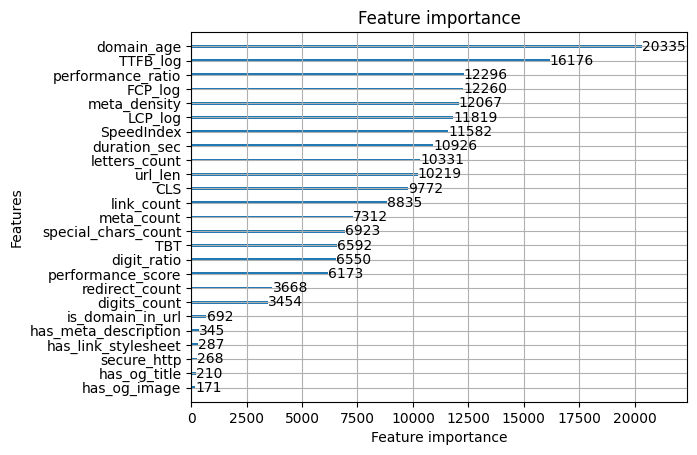

In [11]:
lgb.plot_importance(model, max_num_features=25)